In [13]:
import pdf2image
import numpy as np
import layoutparser as lp
import torchvision.ops.boxes as bops
import torch

In [14]:
pdf_file= '/home/bk/notebook/cv.pdf'
img = np.asarray(pdf2image.convert_from_path(pdf_file)[0])
img1=np.asarray('/home/bk/Bureau/cv.jpeg')
img1

array('/home/bk/Bureau/cv.jpeg', dtype='<U23')

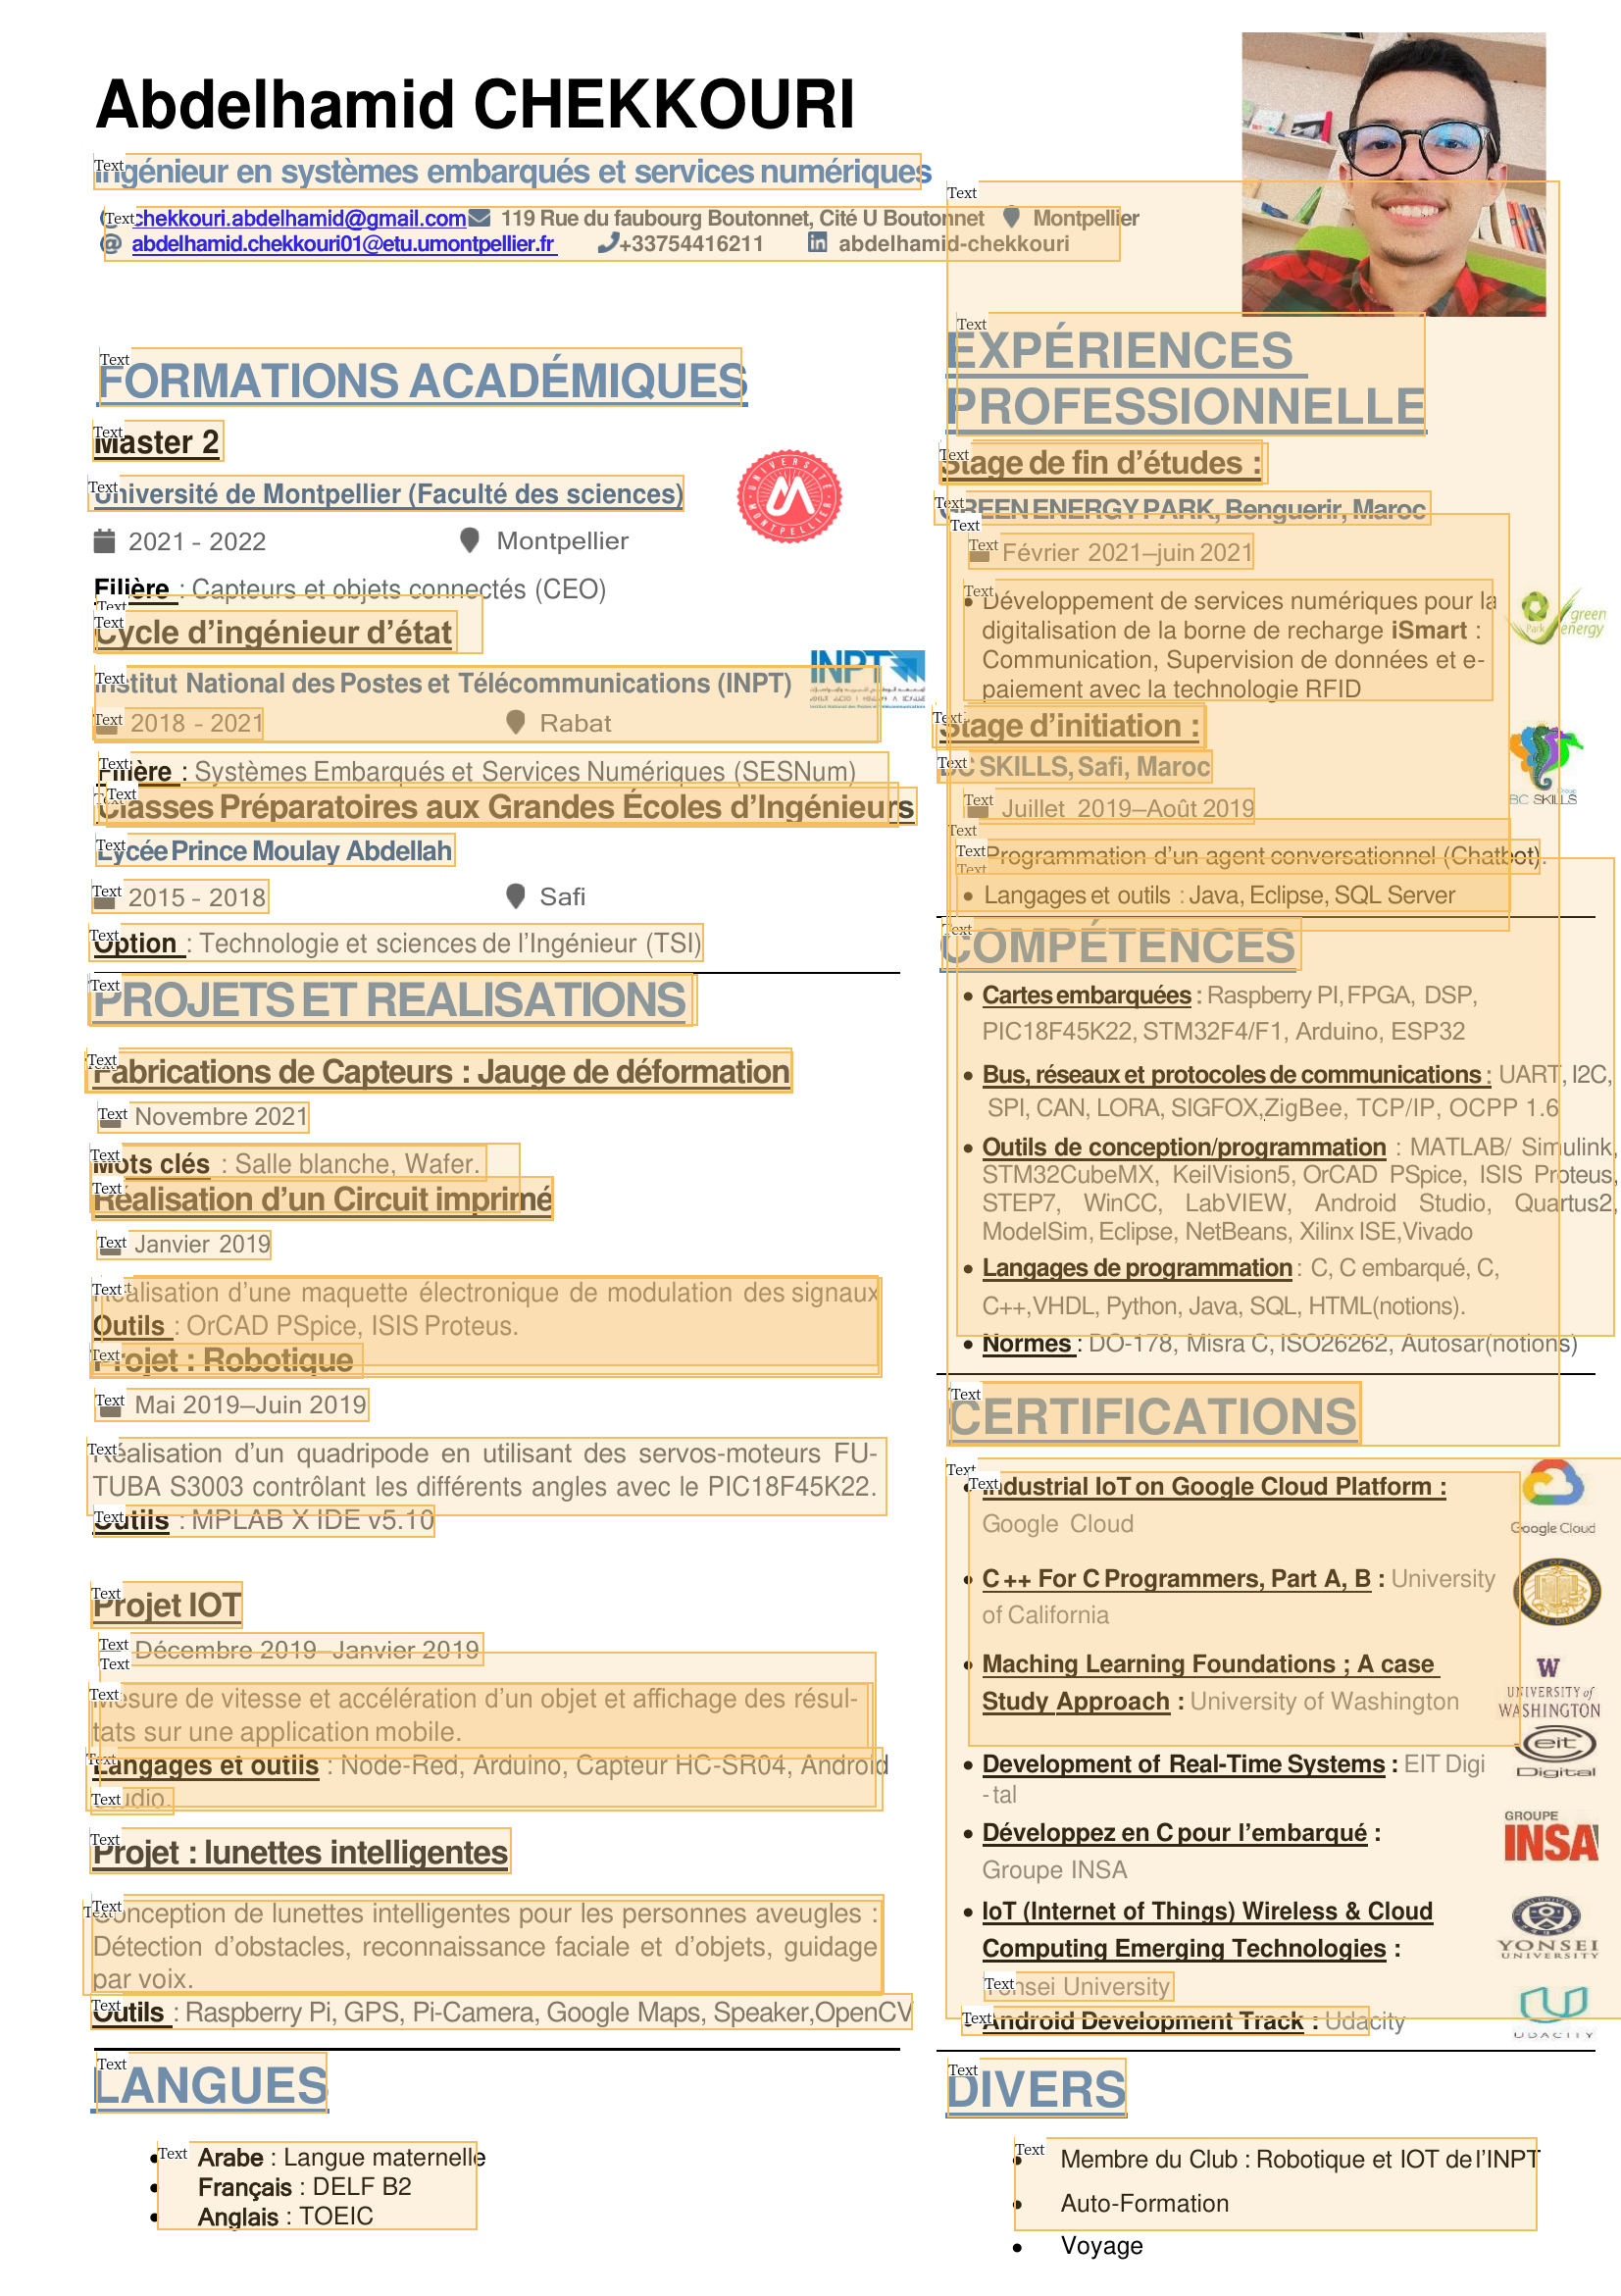

In [21]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.1],
                                 label_map={0: "Text", 1: "Text", 2: "Text", 3:"Text", 4:"Text"})

layout_result = model.detect(img)

lp.draw_box(img, layout_result,  box_width=2, box_alpha=0.2, show_element_type=True)

In [4]:
for a in layout_result:
    print (a)

TextBlock(block=Rectangle(x_1=821.9340209960938, y_1=1752.8814697265625, x_2=1503.516845703125, y_2=2209.7626953125), text=None, id=None, type=Text, parent=None, next=None, score=0.9864938259124756)
TextBlock(block=Rectangle(x_1=814.64892578125, y_1=858.354736328125, x_2=1495.1221923828125, y_2=928.2966918945312), text=None, id=None, type=Text, parent=None, next=None, score=0.9625771045684814)
TextBlock(block=Rectangle(x_1=814.6090087890625, y_1=805.4342041015625, x_2=963.2974243164062, y_2=842.7705688476562), text=None, id=None, type=Text, parent=None, next=None, score=0.9453458786010742)
TextBlock(block=Rectangle(x_1=816.96142578125, y_1=1078.6466064453125, x_2=984.558349609375, y_2=1119.7994384765625), text=None, id=None, type=Text, parent=None, next=None, score=0.9435348510742188)
TextBlock(block=Rectangle(x_1=816.2841186523438, y_1=485.32611083984375, x_2=1455.5626220703125, y_2=515.361328125), text=None, id=None, type=Text, parent=None, next=None, score=0.9322837591171265)
TextBl

In [22]:
text_blocks = lp.Layout([b for b in layout_result ])

In [23]:
import torchvision.ops.boxes as bops
import torch

def set_coordinate(data):

  x1 = data.block.x_1
  y1 = data.block.y_1
  x2 = data.block.x_2
  y2 = data.block.y_2

  return torch.tensor([[x1, y1, x2, y2]], dtype=torch.float)

def compute_iou(box_1, box_2):

  return bops.box_iou(box_1, box_2)

def compute_area(box):

    width = box.tolist()[0][2] - box.tolist()[0][0]
    length = box.tolist()[0][3] - box.tolist()[0][1]
    area = width*length

    return area

def refine(block_1, block_2):

  bb1 = set_coordinate(block_1)
  bb2 = set_coordinate(block_2)

  iou = compute_iou(bb1, bb2)

  if iou.tolist()[0][0] != 0:

    a1 = compute_area(bb1)
    a2 = compute_area(bb2)

    block_2.set(type='None', inplace= True) if a1 > a2 else block_1.set(type='None', inplace= True)
    

for layout_i in text_blocks:
  
    for layout_j in text_blocks:
      
        if layout_i != layout_j: 

            refine(layout_i, layout_j)
            
text_blocks = lp.Layout([b for b in text_blocks ])

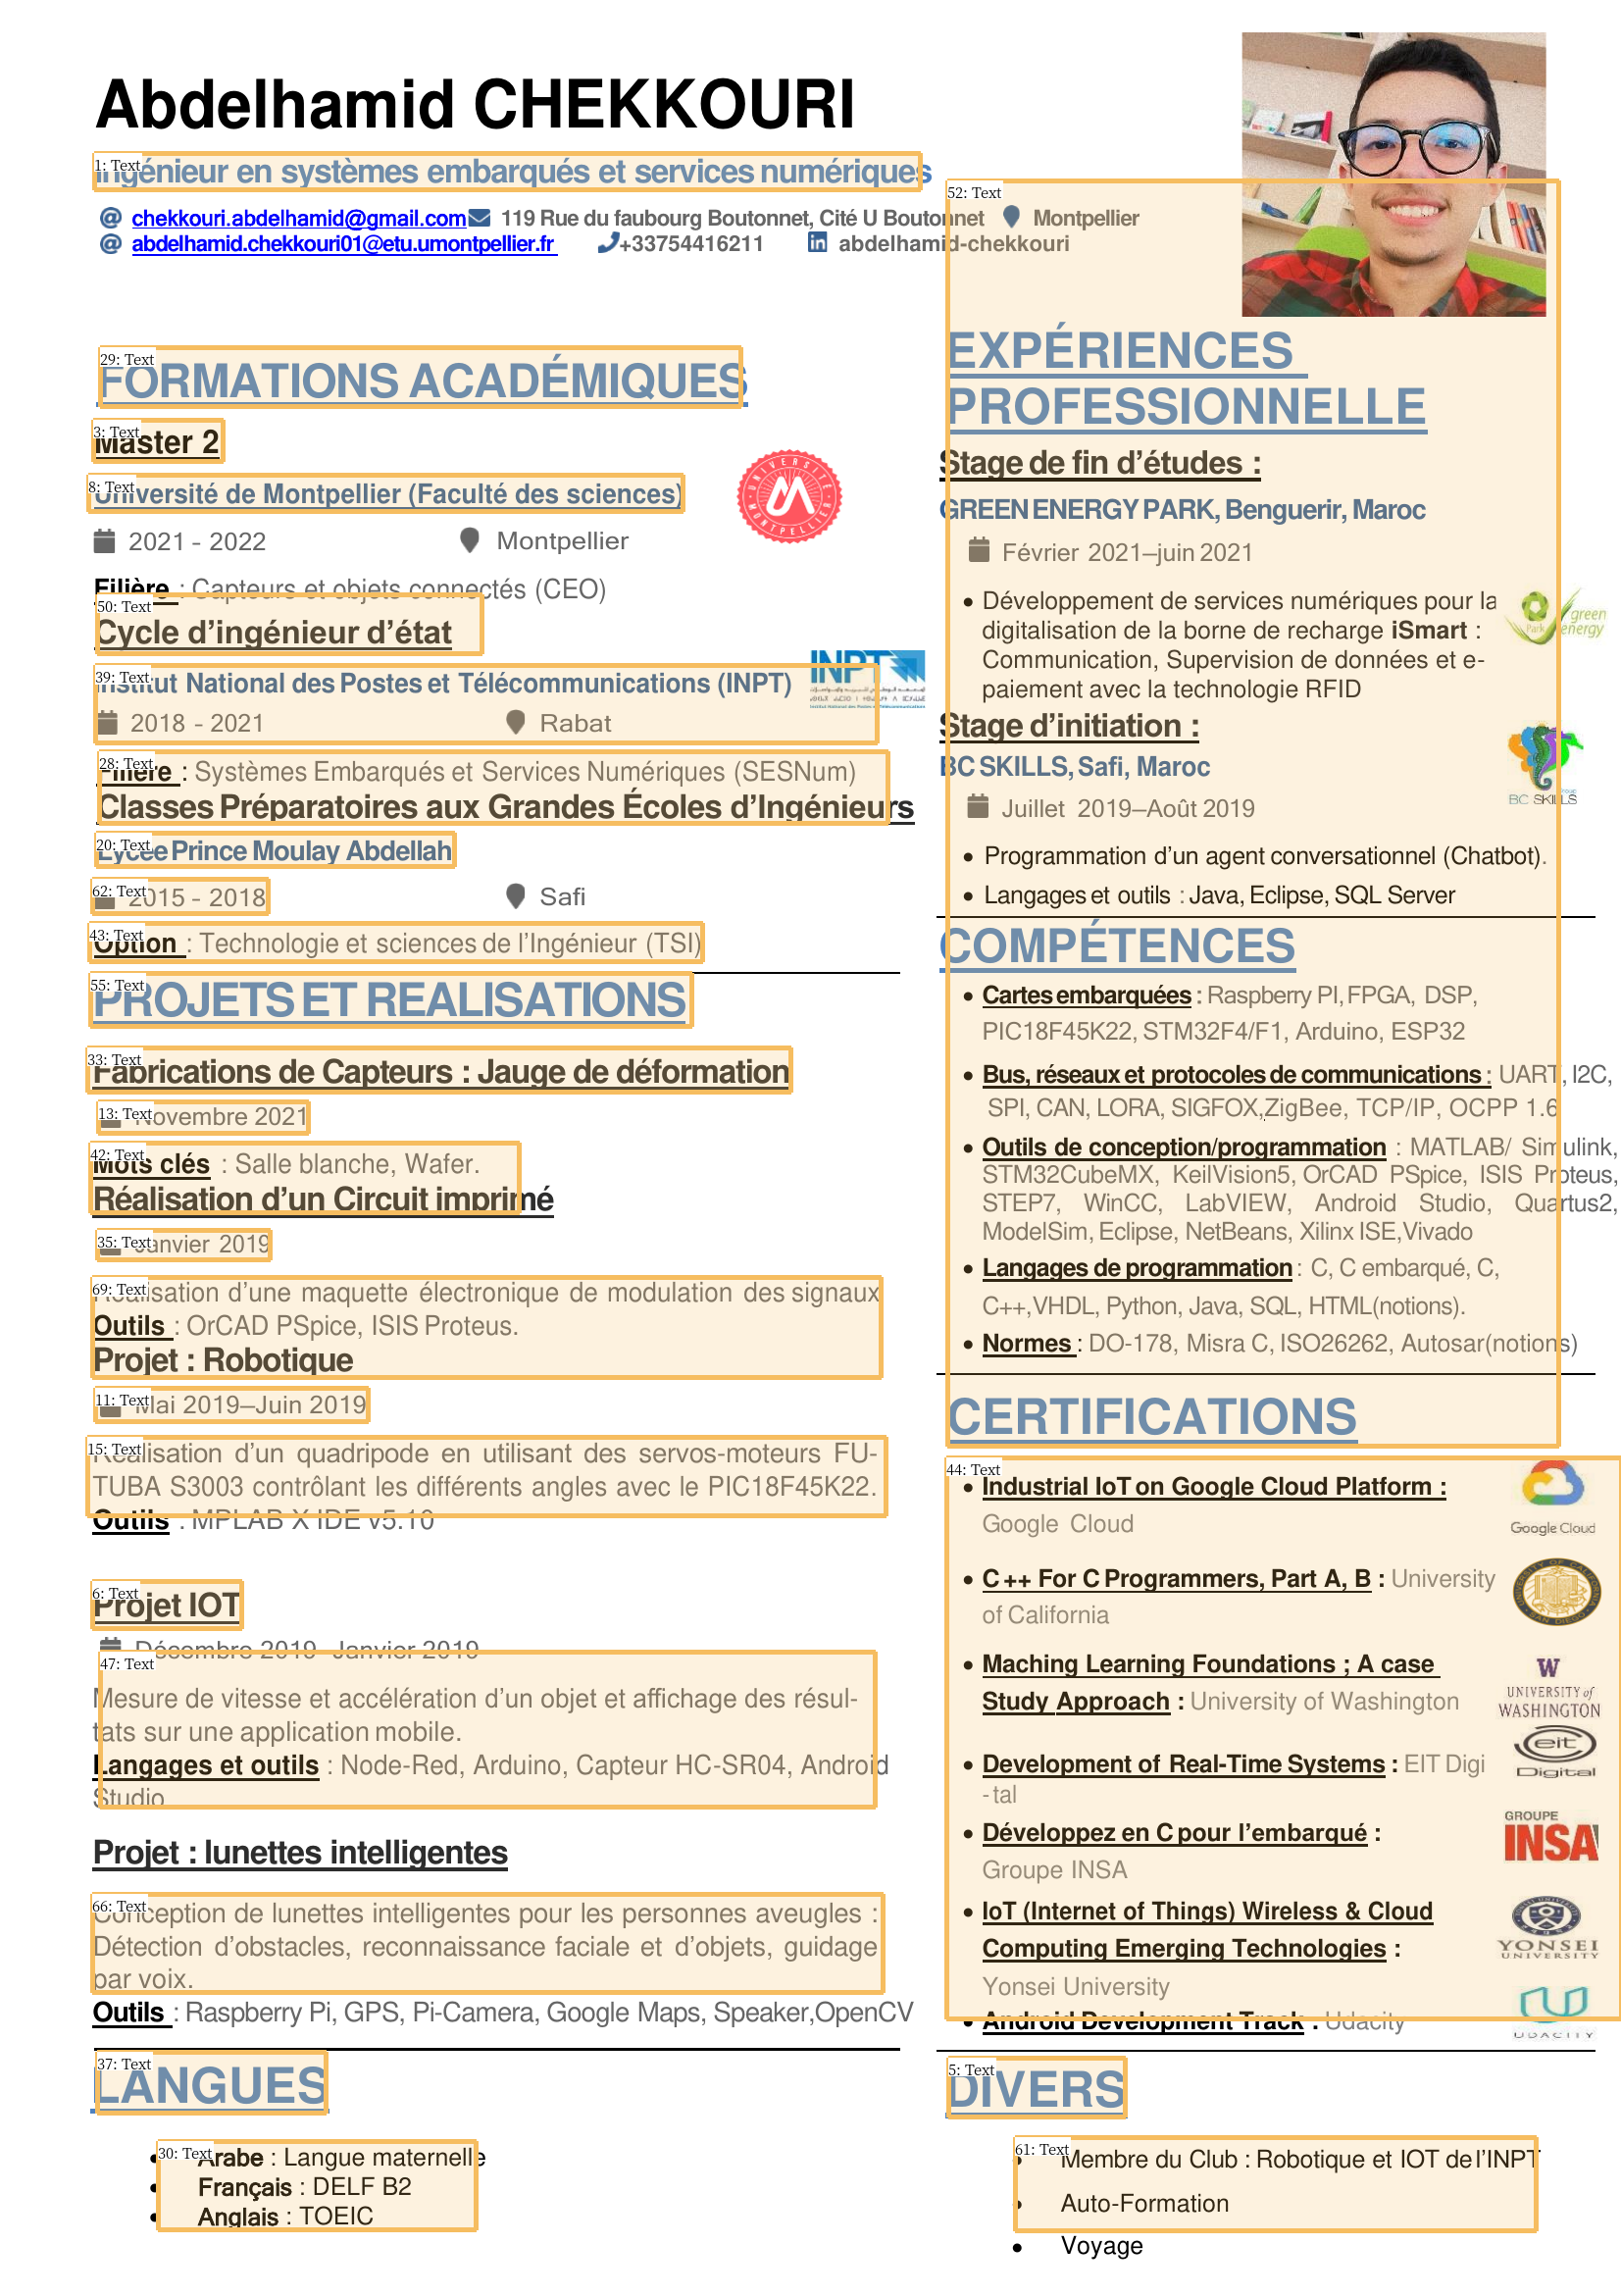

In [24]:
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(text_blocks)])

# From the visualization, we know that layout 
# with 'Diameter Thickness' text has element ID of 4

text_blocks[4].set(type='None', inplace=True)
text_blocks = lp.Layout([b for b in text_blocks if b.type=='Text' ])

lp.draw_box(img, text_blocks,  box_width=5, box_alpha=0.2, show_element_type=True, show_element_id=True)

In [25]:
image_width = len(img[0])

# Sort element ID of the left column based on y1 coordinate
left_interval = lp.Interval(0, image_width/2, axis='x').put_on_canvas(img)
left_blocks = text_blocks.filter_by(left_interval, center=True)._blocks
left_blocks.sort(key = lambda b:b.coordinates[1])

# Sort element ID of the right column based on y1 coordinate
right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# Sort the overall element ID starts from left column
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

In [26]:
ocr_agent = lp.TesseractAgent()

In [27]:
for block in text_blocks:

    # Crop image around the detected layout
    segment_image = (block
                       .pad(left=15, right=15, top=5, bottom=5)
                       .crop_image(img))
    
    # Perform OCR
    text = ocr_agent.detect(segment_image)

    # Save OCR result
    block.set(text=text, inplace=True)

In [11]:
for txt in text_blocks:
    print(txt.text, end='\n---\n')

MAFRAX
KAOUTHAR

ELEVE INGENIEURE EN
ll cae FINANCE A

TRICO CA

  

---
Je suis Kaouthar MAFRAX, éléeve ingénieure
en deuxiéme année en Actuariat-Finance, a
l'Institut National de Statistique et
d'Economie Appliquée (INSEA), je suis a la
recherche active d'un stage d'application de
2 mois a partir de Juillet 2022 en actuariat
ou finance de marché.

---
LANGUES MAITRISEES

---
Arabe : Langue maternelle
Frangais : Courant
Anglais : Courant

---
LOISIRS

---
Montage

---
ACTIVITES PARASCOLAIRES

---
Membre actif de la cellule partenariat du
club INSEA Charity.

Membre actif de la cellule discipline du
club sportif INSEA.

---
COORDONNEES

---
& E-mail : mafraxkaouthar@gmail.com
k.mafrax@insea.ac.ma

© Téléphone : +212624378158

6 Linkedin : Kaouthar Mafrax

---
« INSEA | 2020 - PRESENT

---
Cycle d'ingénieurs en Actuariat-Finance, L'Institut National de Statistique
et d'Economie Appliquée (INSEA ), Rabat

---
¢ CPGE | 2018 - 2020

---
Classes Préparatoires aux Grandes Ecoles